In [1]:
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display

### U-Net diffusion model

In [2]:
class U_Net(Model):

    def __init__(self, image_shape, num_channels, emb_dim=512, gate_filters=32, num_resolutions=4, attn_res_idx=2):
        super().__init__()
        
        self.image_shape = image_shape
        self.num_channels = num_channels
        self.num_resolutions = num_resolutions
        self.attn_res_idx = attn_res_idx
        self.emb_dim = emb_dim
        self.gate_filters = gate_filters
        self.model = self.build_graph()
        
    def timestep_embedding(self, ts, embedding_dim):
        assert len(ts.shape)==1
        
        half_dim = embedding_dim // 2
        emb = -(tf.math.log(10000.0)/(half_dim-1))
        
        idxs = tf.range(half_dim, dtype=tf.float32)
        emb = tf.math.exp(idxs*emb)
        
        ts = tf.cast(ts, dtype=tf.float32)
        
        emb = ts[:,None]* emb[None,:]
        
        pe = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        
        return pe
    
    def nonlinearity(self, x):
        return tf.keras.activations.swish(x)
    
    def normalize(self, x):
        return tfa.layers.InstanceNormalization(axis=-1)(x)
        
    def ResBlK(self, x, temb):
        h = self.nonlinearity(self.normalize(x))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        temb = self.nonlinearity(temb)
        h +=  tf.reshape(layers.Dense(h.shape[-1])(temb), (-1, 1, 1,h.shape[-1]))
        
        h = self.nonlinearity(self.normalize(h))
        h = layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        return x+h
        
    def downsample(self, x, filters, factor=2):
        return layers.Conv2D(filters, (3, 3),
                                        strides=(factor, factor), padding='same')(x)

    def upsample(self, x, filters, factor=2):
        return layers.Conv2DTranspose(filters, (3, 3),
                                       strides=(factor, factor), padding='same')(x)
        
    def NonlocalGaussian(self, x):
        h = self.normalize(x)
        theta = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        g = layers.Conv2D(x.shape[-1]/2.0, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        phi = tf.transpose(phi, (0, 3, 2, 1))

        theta = tf.reshape(theta, shape=(-1, theta.shape[1]*theta.shape[2], theta.shape[3]))

        phi = tf.reshape(phi, shape=(-1, phi.shape[1], phi.shape[2]*phi.shape[3]))
        g = tf.reshape(g, shape=(-1, g.shape[1]*g.shape[2], g.shape[3]))
        
        f = tf.matmul(theta, phi)
        
        f = layers.Softmax()(f)
        
        y = tf.matmul(f, g)
        
        y = tf.reshape(y, (-1, x.shape[1], x.shape[2], y.shape[-1]))
        
        z = tf.math.add(x, layers.Conv2D(x.shape[-1], (1, 1),
                                        strides=(1, 1), padding='same')(y))
        return z
    
    def design(self, img_input, t):
        
        temb = self.timestep_embedding(t, self.emb_dim)
        
        hs = [layers.Conv2D(self.gate_filters, (1, 1),
                                        strides=(1, 1), padding='same')(img_input)]
        for i in range(self.num_resolutions):
            h = self.ResBlK(hs[-1], temb)
            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != self.num_resolutions - 1:
                h = self.downsample(h, h.shape[-1]*2)
                
            hs.append(h)

        h = hs[-1]
        h = self.ResBlK(h, temb)
        h = self.NonlocalGaussian(h)
        h = self.ResBlK(h, temb)
                
        for i in reversed(range(self.num_resolutions)):
            h = h+hs[i]
            h = self.ResBlK(h, temb)

            if i == self.attn_res_idx:
                h = self.NonlocalGaussian(h)
                
            if i != 0:
                h = self.upsample(h, h.shape[-1]//2)
        
                
        h = self.nonlinearity(self.normalize(h))
        
        h = layers.Conv2D(self.num_channels, (1, 1),
                                        strides=(1, 1), padding='same')(h)
        
        
        return h
    
    def call(self, x, t):
        return self.model([x,t])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channels))
        
        t = layers.Input(shape=())
        
        return Model(inputs=[x,t], outputs=self.design(x,t))
        

In [3]:
u_net1 = U_Net((64,64), 3)

2022-10-28 14:49:47.427512: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:47.434620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:47.434800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 14:49:47.435378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
img_in = tf.random.normal((3, 64,64,3))
t = tf.random.uniform((3,),maxval=1000, dtype=tf.int32)
img_in.shape, t

(TensorShape([3, 64, 64, 3]),
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([467, 785, 700], dtype=int32)>)

In [5]:
u_net1(img_in, t)

2022-10-28 14:49:52.382847: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-28 14:49:52.739662: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


<tf.Tensor: shape=(3, 64, 64, 3), dtype=float32, numpy=
array([[[[-3.75157744e-01,  2.86670979e-02, -2.24296376e-01],
         [-3.38197112e-01,  3.20145220e-01, -6.44464135e-01],
         [ 1.37339607e-01, -1.17772035e-01,  1.00884274e-01],
         ...,
         [-3.95094544e-01, -5.17110765e-01,  1.06567001e+00],
         [ 3.53442967e-01, -6.57804608e-01,  1.72830727e-02],
         [-3.27869117e-01,  4.48736429e-01, -7.62477338e-01]],

        [[-3.62427264e-01,  2.69196052e-02,  4.56830382e-01],
         [-4.54022229e-01,  1.34098023e-01,  2.04760924e-01],
         [-5.33171058e-01,  2.76301056e-01,  6.26226485e-01],
         ...,
         [-3.68035823e-01,  1.93972617e-01, -2.52192616e-01],
         [ 4.79935139e-01, -7.99155653e-01,  2.14868188e+00],
         [-7.16260299e-02,  8.57240915e-01, -2.16904312e-01]],

        [[-4.47871655e-01, -9.20248181e-02, -4.98447567e-01],
         [-3.91507268e-01,  2.49310240e-01, -2.27814421e-01],
         [-5.49729407e-01, -2.78302598e+00, 

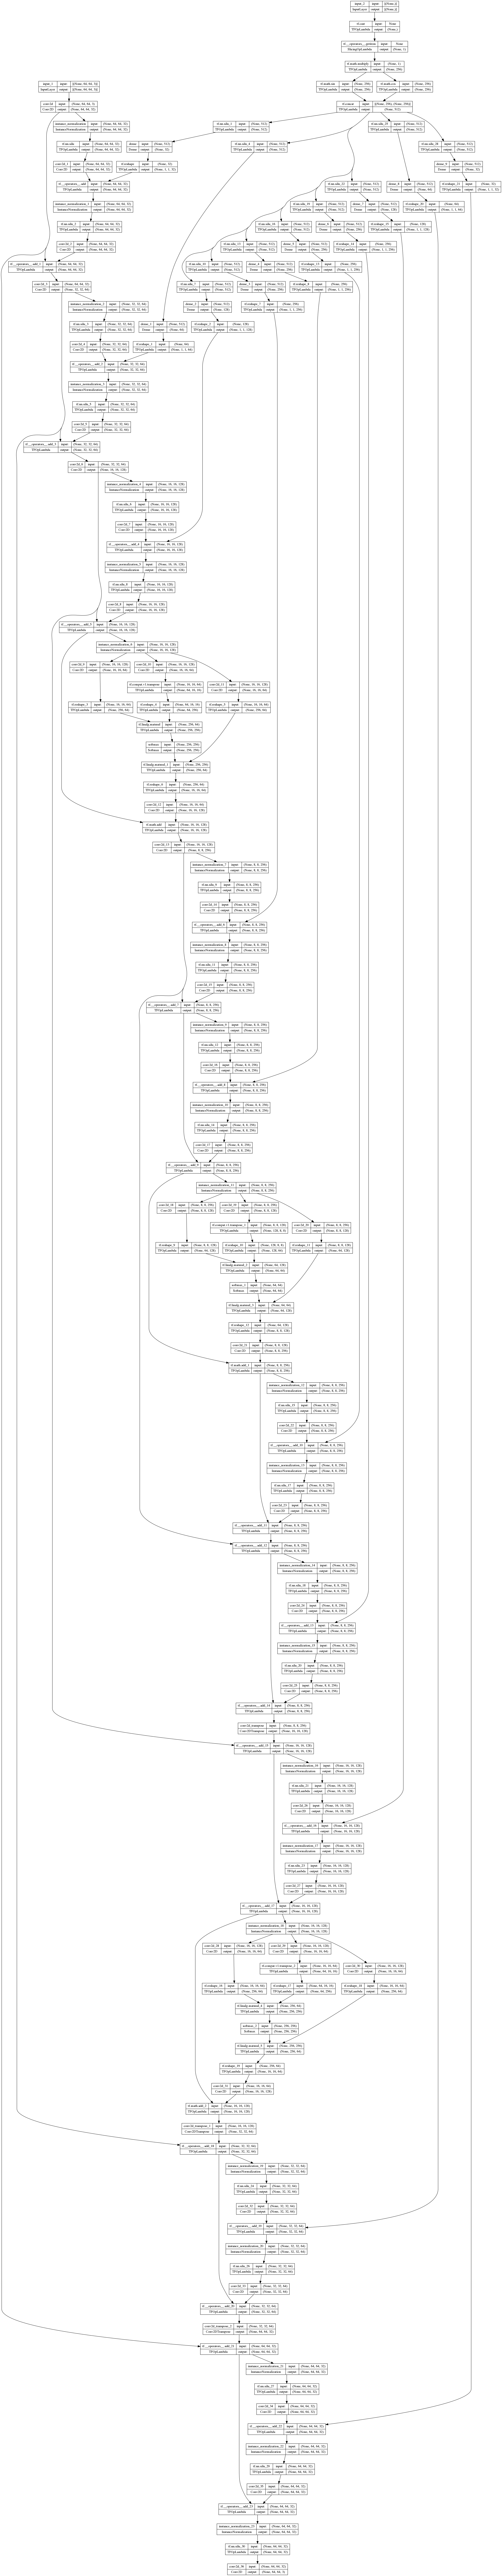

In [6]:
tf.keras.utils.plot_model(u_net1.model, show_shapes=True)

### Gaussian Diffusion

#### Modified from official implementation

In [7]:
class GSDDPM:
    
    def __init__(self, image_shape, num_channel, dataset_path=None, total_timestamps=1000, beta_start=1e-4, beta_end=0.02,
                 batch_size=64, lr=3e-4):
        assert len(image_shape) == 2
        
        self.imgsp, self.nc, self.dp, self.tt, self.bs, self.lr = image_shape, num_channel, dataset_path, total_timestamps, batch_size, lr
        self.denoise_unet = U_Net(self.imgsp, self.nc)
        
        betas = self.get_betas(total_timestamps, beta_start, beta_end)
        
        alphas = 1. - betas
        alphas_cuprod = np.cumprod(alphas)
        alphas_cuprod_prev = np.append(1., alphas_cuprod[:-1])
        
        self.betas = tf.constant(betas)

        self.sqrt_alphas_cuprod = tf.constant(np.sqrt(alphas_cuprod), dtype=tf.float64)
        self.sqrt_one_minus_alphas_cuprod = tf.constant(np.sqrt(1. - alphas_cuprod), dtype=tf.float64)
        self.log_one_minus_alphas_cuprod = tf.constant(np.log(1. - alphas_cuprod), dtype=tf.float64)
        self.sqrt_recip_alphas_cuprod = tf.constant(np.sqrt(1. / alphas_cuprod), dtype=tf.float64)
        self.sqrt_recipm1_alphas_cuprod = tf.constant(np.sqrt(1. / alphas_cuprod - 1), dtype=tf.float64)
    
        posterior_variance = betas * (1. - alphas_cuprod_prev) / (1. - alphas_cuprod)
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float64)
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float64)
        self.posterior_mean_coef1 = tf.constant(
          betas * np.sqrt(alphas_cuprod_prev) / (1. - alphas_cuprod), dtype=tf.float64)
        self.posterior_mean_coef2 = tf.constant(
          (1. - alphas_cuprod_prev) * np.sqrt(alphas) / (1. - alphas_cuprod), dtype=tf.float64)

        
        self.opt = tf.keras.optimizers.Adam(self.lr)
        
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.imgsp,
                                  batch_size=self.bs)
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
    
    def get_betas(self, ts, bs, be):
        
        betas = np.linspace(bs, be, ts, dtype=np.float64)

        return betas
    
    def q_sample(self, xs, ts, epsilon): 
        
        return tf.reshape(tf.gather(self.sqrt_alphas_cuprod, ts), (ts.shape[0],1,1,1))*xs + tf.reshape(tf.gather(self.sqrt_one_minus_alphas_cuprod, ts), (ts.shape[0],1,1,1))*epsilon
    
    def q_pos(self, xss, xs, ts):
        pm =  tf.reshape(tf.gather(self.posterior_mean_coef1, ts), (ts.shape[0],1,1,1)) * xss + tf.reshape(tf.gather(self.posterior_mean_coef2, ts), (ts.shape[0],1,1,1)) * xs
        p_var = tf.gather(self.posterior_variance, ts)
        p_log_var = tf.gather(self.posterior_log_variance_clipped, ts)
        
        return pm, p_var, p_log_var
    
    def start_from_noise(self, xs, ts, noise):
        return tf.reshape(tf.gather(self.sqrt_recip_alphas_cuprod, ts), (ts.shape[0],1,1,1)) * xs - tf.reshape(tf.gather(self.sqrt_recipm1_alphas_cuprod, ts), (ts.shape[0],1,1,1)) * noise
    
    def pos_mean_var(self, xs, ts):
        
        x_recon = tf.clip_by_value(self.start_from_noise(xs, ts, tf.cast(self.denoise_unet(xs, ts), dtype=tf.float64)), -1., 1.)
        return self.q_pos(x_recon, xs, ts)
    
    def p_sample(self, xs, ts): 
        
        mm, pv, log_pv = self.pos_mean_var(xs, ts)
        nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(ts, 0), tf.float64), [xs.shape[0]] + [1] * (len(xs.shape) - 1))
        noise = tf.random.normal(xs.shape, dtype=tf.float64)
        
        return mm + nonzero_mask * tf.reshape(tf.exp(0.5 * log_pv), (noise.shape[0],1,1,1)) * noise
          
    def p_losses(self, xs, ts):
        
        epsilon = tf.random.normal(shape=xs.shape, dtype=tf.float64)
                               
        x_noisy = self.q_sample(xs=tf.cast(xs,dtype=tf.float64), ts=ts, epsilon=epsilon)
        x_recon = tf.cast(self.denoise_unet(x_noisy, ts), dtype=tf.float64)
                               
        losses = tf.reduce_mean(tf.math.squared_difference(epsilon, x_recon), axis=list(range(1, len(epsilon.shape))))

        return losses

    def p_sample_to_img(self, batch_size=None):
        
        if batch_size == None:
            batch_size = self.bs
        imgs = tf.random.normal((batch_size, self.imgsp[0], self.imgsp[1], self.nc), dtype=tf.float64)
        i_t = self.tt - 1
        
        while i_t >= 0:
            self.denoise_unet
            imgs = self.p_sample(imgs, tf.fill([batch_size], i_t))
            
            i_t = i_t - 1
        
        return (imgs + 1.)/2
    
    @tf.function
    def update(self, xs, ts):
         with tf.GradientTape() as tape:
            loss = tf.reduce_mean(self.p_losses(xs, ts))
        
         grad = tape.gradient(loss, self.denoise_unet.trainable_variables)
        
         self.opt.apply_gradients(zip(grad, self.denoise_unet.trainable_variables))
        
         return loss
    def train(self, epochs=250):
        for epo in range(epochs):
            losses = []
            for img_b, l_b in self.dataset:
                t_b = tf.random.uniform((img_b.shape[0],),maxval=1000, dtype=tf.int32)
                img_b = (img_b-127.5)/127.5 
                loss = self.update(img_b, t_b)
                losses.append(loss)
                
            print("Epoch {:04d}".format(epo), "Avg. Loss: ", np.mean(losses), flush=True)
    
        
        

In [8]:
ds_path = "/home/data_backup/data_bu/mnist_jpg/training"

In [9]:
dm1 = GSDDPM((64,64), 3, ds_path)

Found 60000 files belonging to 10 classes.


In [10]:
ds = tf.keras.utils.image_dataset_from_directory(
                  ds_path,
                  seed=123,
                  image_size=(64,64),
                  batch_size=64)

Found 60000 files belonging to 10 classes.


In [11]:
for i, l in ds.take(1):
    print(i.shape)

(64, 64, 64, 3)


In [12]:
ts = tf.random.uniform((64,),maxval=1000, dtype=tf.int32)

In [176]:
for imgs, ls in ds.take(1):
    print(dm1.update(imgs, ts))

tf.Tensor(2.086078866843784, shape=(), dtype=float64)


In [212]:
dm1.train(200)

Epoch 0000 Avg. Loss:  0.0049455091462695345
Epoch 0001 Avg. Loss:  0.004936257715202943
Epoch 0002 Avg. Loss:  0.004849562472565152
Epoch 0003 Avg. Loss:  0.004787258168169818
Epoch 0004 Avg. Loss:  0.004870756743290744
Epoch 0005 Avg. Loss:  0.0050069573611492045
Epoch 0006 Avg. Loss:  0.004898684343736336
Epoch 0007 Avg. Loss:  0.004845770361388931
Epoch 0008 Avg. Loss:  0.00487028376177725
Epoch 0009 Avg. Loss:  0.0048500357254924525
Epoch 0010 Avg. Loss:  0.004816485734762051
Epoch 0011 Avg. Loss:  0.0048571125999100915
Epoch 0012 Avg. Loss:  0.0048101859563070976
Epoch 0013 Avg. Loss:  0.004709306504134663
Epoch 0014 Avg. Loss:  0.004796445931037608
Epoch 0015 Avg. Loss:  0.004851995037658859
Epoch 0016 Avg. Loss:  0.004765078175483244
Epoch 0017 Avg. Loss:  0.004700424585157596
Epoch 0018 Avg. Loss:  0.004650824093074975
Epoch 0019 Avg. Loss:  0.004852009966597202
Epoch 0020 Avg. Loss:  0.004834892908620175
Epoch 0021 Avg. Loss:  0.004680737924436199
Epoch 0022 Avg. Loss:  0.004

Epoch 0187 Avg. Loss:  0.004066208235036315
Epoch 0188 Avg. Loss:  0.004156581023523655
Epoch 0189 Avg. Loss:  0.0039779662719620894
Epoch 0190 Avg. Loss:  0.00404032292527157
Epoch 0191 Avg. Loss:  0.004048826352107061
Epoch 0192 Avg. Loss:  0.004048792224224514
Epoch 0193 Avg. Loss:  0.004060972085089683
Epoch 0194 Avg. Loss:  0.004083786429746404
Epoch 0195 Avg. Loss:  0.004065154928838815
Epoch 0196 Avg. Loss:  0.004102942440197245
Epoch 0197 Avg. Loss:  0.004079999612417559
Epoch 0198 Avg. Loss:  0.00406576910243487
Epoch 0199 Avg. Loss:  0.004113483195827707


In [209]:
img1 = dm1.p_sample_to_img(2)

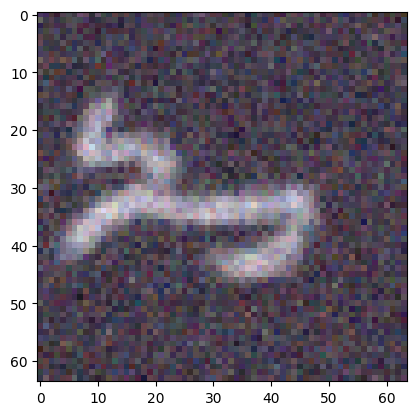

In [211]:
plt.imshow(img1[1])

### Cleaned up implementation

In [13]:
class DM:
    
    def __init__(self, image_shape, num_channel, dataset_path=None, total_timestamps=1000, beta_start=1e-4, beta_end=0.02,
                 batch_size=64, lr=3e-4):
        assert len(image_shape) == 2
        
        self.imgsp, self.nc, self.dp, self.tt, self.bs, self.lr = image_shape, num_channel, dataset_path, total_timestamps, batch_size, lr
        self.denoise_unet = U_Net(self.imgsp, self.nc)
        
        betas = self.get_betas(total_timestamps, beta_start, beta_end)
        
        alphas = 1. - betas
        alphabart = np.cumprod(alphas)
        alphasartminusone = np.append(1., alphabart[:-1])
        
        self.logsigmatsq = tf.constant(np.log(np.maximum(((1.-alphasartminusone)/(1.-alphabart))*betas, 1e-20)))
        self.samp_coef1 = tf.constant(1./np.sqrt(alphas))
        self.samp_coef2 = tf.constant((1. - alphas)/(np.sqrt(1.-alphabart)))
        
        self.noise_coef1 = tf.constant(np.sqrt(alphabart))
        self.noise_coef2 = tf.constant(np.sqrt(1.-alphabart))
        
        self.opt = tf.keras.optimizers.Adam(self.lr)
        
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.imgsp,
                                  batch_size=self.bs)
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
    
    def get_betas(self, ts, bs, be):
        
        betas = np.linspace(bs, be, ts, dtype=np.float64)

        return betas
          
    def loss_func(self, xs, ts):
        
        epsilon = tf.random.normal(shape=xs.shape, dtype=tf.float64)
        
        term_1 = tf.reshape(tf.gather(self.noise_coef1, ts), (ts.shape[0],1,1,1))*tf.cast(xs,dtype=tf.float64)
        term_2 = tf.reshape(tf.gather(self.noise_coef2, ts), (ts.shape[0],1,1,1))*epsilon
        
        epsilon_theta = tf.cast(self.denoise_unet(term_1+term_2, ts), dtype=tf.float64)
                               
        losses = tf.reduce_mean(tf.math.squared_difference(epsilon, epsilon_theta), axis=list(range(1, len(epsilon.shape))))

        return losses

    def sample(self, batch_size=None):
        
        if batch_size == None:
            batch_size = self.bs
        xts = tf.random.normal((batch_size, self.imgsp[0], self.imgsp[1], self.nc), dtype=tf.float64)
        i_t = self.tt - 1
        
        while i_t >= 0:

            ts = tf.fill([batch_size], i_t)
            coef1 = tf.reshape(tf.gather(self.samp_coef1, ts), (ts.shape[0],1,1,1))
            coef2 = tf.reshape(tf.gather(self.samp_coef2, ts), (ts.shape[0],1,1,1))
            
            
            epsilon_theta = tf.cast(self.denoise_unet(xts, ts), dtype=tf.float64)
            
            nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(ts, 0), tf.float64), [xts.shape[0]] + [1] * (len(xts.shape) - 1))
            zeta = tf.random.normal(xts.shape, dtype=tf.float64)
            sigmat = tf.reshape(tf.exp(0.5* self.logsigmatsq), (noise.shape[0],1,1,1))
            
            xts = coef1*(xts - coef2*epsilon_theta) + nonzero_mask*sigmat*zeta
            
            i_t = i_t - 1
        
        return (imgs + 1.)/2
        
    @tf.function
    def update(self, xs, ts):
         with tf.GradientTape() as tape:
            loss = tf.reduce_mean(self.loss_func(xs, ts))
        
         grad = tape.gradient(loss, self.denoise_unet.trainable_variables)
        
         self.opt.apply_gradients(zip(grad, self.denoise_unet.trainable_variables))
        
         return loss
    def train(self, epochs=250):
        for epo in range(epochs):
            losses = []
            for img_b, l_b in self.dataset:
                t_b = tf.random.uniform((img_b.shape[0],),maxval=1000, dtype=tf.int32)
                img_b = (img_b-127.5)/127.5 
                loss = self.update(img_b, t_b)
                losses.append(loss)
                
            print("Epoch {:04d}".format(epo), "Avg. Loss: ", np.mean(losses), flush=True)
    
    

In [14]:
ds_path = "/home/data_backup/data_bu/mnist_jpg/training"

In [15]:
dm2 = DM((64,64),3, ds_path)

Found 60000 files belonging to 10 classes.


In [ ]:
dm2.train(200)